### Occlude parts of the image & store the change in activation 

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import argparse
import shutil
import pandas as pd
import cornet 
import scipy.misc
from PIL import Image
import PIL.ImageOps
import json
import csv
import os, random
import seaborn as sns
sns.set(style="white")
import glob
import os.path as op
%matplotlib inline



In [18]:
tfms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),  transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225])  + torch.Tensor([0.485, 0.456, 0.406])

def load_image(path):
    image = Image.open(path).convert("RGB")
    #plt.imshow(image)
    #plt.title("Image loaded successfully")
    return image

### Loop across files 

In [19]:
def recursivelistims(path):
    """Function to load images [.jpg, .jpeg, .png] from a given path
    """
    l = []
    if os.path.isfile(path):
        return [path]
    else:
        for dirpath, dirnames, filenames in os.walk(path):
            for fname in filenames:
                if fname.lower().endswith('.jpg') or fname.lower().endswith('.jpeg') or fname.lower().endswith(
                        '.png'):
                    l.append(os.path.join(dirpath, fname))
                    #print(fname)
    return sorted(l)

def trans(img):
    t = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    img = t(img).view(1,1,224,224)
    return img

#define path to stimuli/images
model = 'resnet10'
condition = 'a_background'
input_path = '/home/nseijde1/Projects/Imagesets/imagenet_format/'+ condition +'/'

# Find images
imagefiles = recursivelistims(input_path)
print('Number of images found: %s' % len(imagefiles))
images = torch.zeros(1, 3, 224, 224)


import os, fnmatch
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result


labels = json.load(open('/home/nseijde1/Projects/scenecontext/backgroundtypicality/imagenet_class_index.json'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Number of images found: 729


In [20]:
import cornet 
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class noresBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(noresBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
            
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet6(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet6, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=7, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.avgpool = nn.AvgPool2d(28, stride=1)
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    

def resnet6(pretrained=False, **kwargs):
    model = ResNet6(noresBasicBlock, [1, 1, 1, 1], **kwargs)
    return model


In [ ]:
#define path to stimuli/images
condition = 'a_background'
input_path = '/home/nseijde1/Projects/Imagesets/imagenet_format/'+ condition +'/'

# Find images
imagefiles = recursivelistims(input_path)
print('Number of images found: %s' % len(imagefiles))

models = ['resnet6','resnet10','resnet18','resnet34','resnet50','resnet101','resnet152', 'cornet_z', 'cornet_rt', 'cornet_s' ]
#models = ['resnet6','resnet10','resnet18']

patchsize=[128,169]
coordinates = []
for xc in range(0,(544-(patchsize[0])), 32):
    for yc in range(0, (544-(patchsize[0])), 32):
        coordinates.append((xc,yc))
        
def predict(image):
    output = model_conv.forward(image)
    log = output.tolist()[0][corr_class]
    _,indices = torch.sort(output, descending=True)
    if corr_class in indices[0][:5]:
        Top5="yes"
    else:
        Top5="no"
    return log,Top5

heatmap = np.full((512, 512, patchsize[1]), np.nan)

for model in models:
    # load model
    if model == 'resnet6':
        model_conv = ResNet6(noresBasicBlock, [1,1,1,1])
        model_conv = torch.nn.DataParallel(model_conv)
        checkpoint = torch.load('/home/nseijde1/Projects/scenecontext/backgroundtypicality/modellen/net6/model_best.pth.tar', map_location='cpu')
        model_conv.load_state_dict(checkpoint['state_dict'])
    elif model == 'resnet10':
        model_conv = ptcv_get_model('resnet10', pretrained=True)
    elif model.startswith('resnet'):
        model_conv = torchvision.models.__dict__[model](pretrained=True)
    else:
        model_conv = getattr(cornet, model)
        model_conv = model_conv(pretrained=True, map_location= 'cpu')
        
    print(model_conv)
    model_conv.eval()
    
    del(heatmap)

    mean_obj_interference = []
    mean_bg_interference = []
    with open('2804final_objectinterference_'+ model+ '_' + condition, 'w') as myfile:
        wr = csv.writer(myfile)
        aii = ['condition', 'model', 'obj','img', 'obj_interf', 'bg_interf','top5','orig','orig_top5']
        wr.writerow(aii)

        for imgfile in imagefiles[2:]:
            print(imgfile[-35:-4])
            img = load_image(imgfile)

            object_mask = find(imgfile[-35:-12] + '*png', '/home/nseijde1/Projects/Imagesets/masking/object')
            background_mask = find(imgfile[-35:-12] + '*png', '/home/nseijde1/Projects/Imagesets/masking/background')
            corr_class = int(object_mask[0].split("/")[-2])-1
            print(corr_class)

            
            object_im = np.array(Image.open(object_mask[0]).convert('1'))
            background_im = np.array(Image.open(background_mask[0]).convert('1'))
            object_im = np.array(object_im)
            background_im = np.array(background_im)
            
            img_tensor = tfms(img).unsqueeze(0)

            Origlog,Origt5 = predict(img_tensor)
            print("Original logits: ", Origlog)
            
            heatmap = np.full((512, 512, patchsize[1]), np.nan)

            for loci in range(patchsize[1]):
                
                input_image = np.array(img, copy=True)
                input_image[coordinates[loci][0]:coordinates[loci][0]+128, coordinates[loci][1]:coordinates[loci][1]+128,:] =  (128,128,128)
                input_image = Image.fromarray(input_image)
                input_image=tfms(input_image).unsqueeze(0)

                log,t5 = predict(input_image)
                heatmap[coordinates[loci][0]:coordinates[loci][0]+128, coordinates[loci][1]:coordinates[loci][1]+128,loci] = Origlog-log # the probability of the correct class
                del log

            meanarray = np.nanmean(heatmap, axis=2)
            meanmap = pd.DataFrame(meanarray)

            object_copy = meanmap.copy()
            background_copy=meanmap.copy()
            
            object_copy[object_im==False] = np.nan
            background_copy[background_im==False]= np.nan   

            obj_interference = np.nanmean(object_copy)
            bg_interference = np.nanmean(background_copy)

            aa = [condition, model, corr_class,imgfile[-35:-4], obj_interference, bg_interference, t5, Origlog, Origt5]
            wr.writerow(aa)

            


### After performing analysis for all networks + conditions, perform stats + plot average values:

In [4]:
all_files = glob.glob(op.join('/home/nseijde1/Projects/scenecontext/backgroundtypicality/Analysis', "2804final_objectinterference_*"))
all_df = []

for f in all_files:
    df=pd.read_csv(f,sep=",")
    all_df.append(df)
    
merged_df = pd.concat(all_df, ignore_index=True, sort=True)
merged_df.drop(columns=['top5'],inplace=True)

merged_df = merged_df[merged_df['orig_top5']=="yes"].sort_values(by=['model','img'])
#merged_df = merged_df[merged_df['orig']>1]

resnets = merged_df[merged_df['model'].str.startswith('resnet',na=False)]
resnets = pd.melt(resnets,id_vars=['model', 'condition', 'img', 'obj','orig','orig_top5'], var_name='obj_bg',value_name='interf')
resnets['interf_ratio']=resnets['interf']/abs(resnets['orig'])

cornets= merged_df[merged_df['model'].str.startswith('cornet',na=False)]
cornets = pd.melt(cornets,id_vars=['model', 'condition', 'img', 'obj','orig','orig_top5'], var_name='obj_bg',value_name='interf')
cornets['interf_ratio']=cornets['interf']/abs(cornets['orig'])


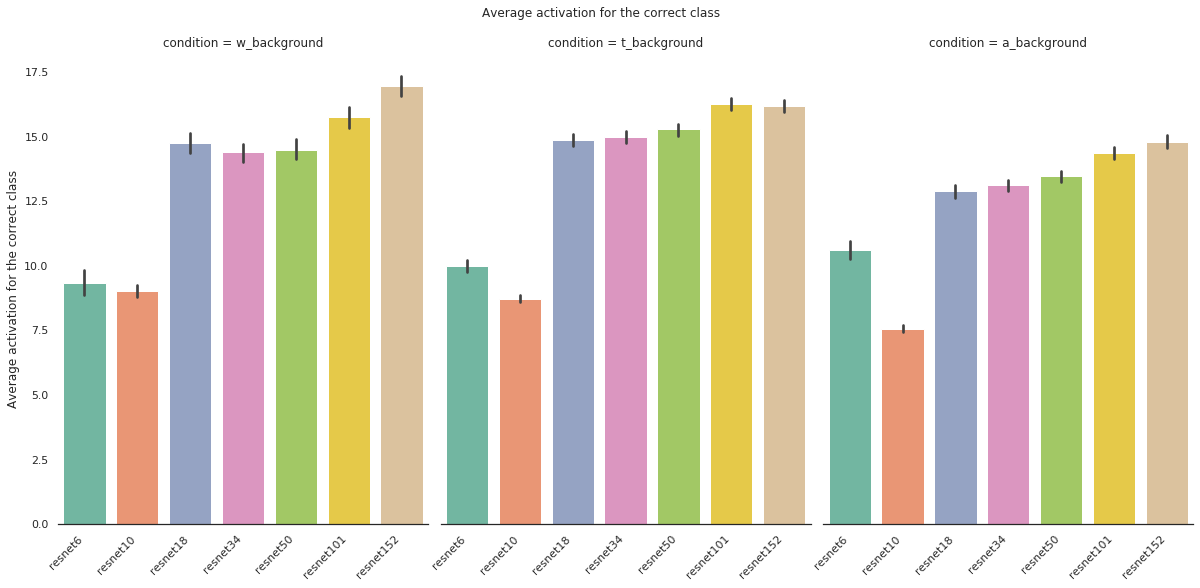

In [5]:
g = sns.catplot(x="model", y="orig",
                col="condition",
                data=resnets, kind="bar",
                col_order=["w_background", "t_background","a_background"],
                order=["resnet6", "resnet10", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152"],
                palette="Set2",
                ci=95,
                height=8, aspect=.7);

(g.set_axis_labels("", "Average activation for the correct class")
  .despine(left=True))

g.set_xticklabels(rotation=45,horizontalalignment='right')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average activation for the correct class') # can also get the figure from plt.gcf()
plt.savefig("Activation.pdf", dpi=300)

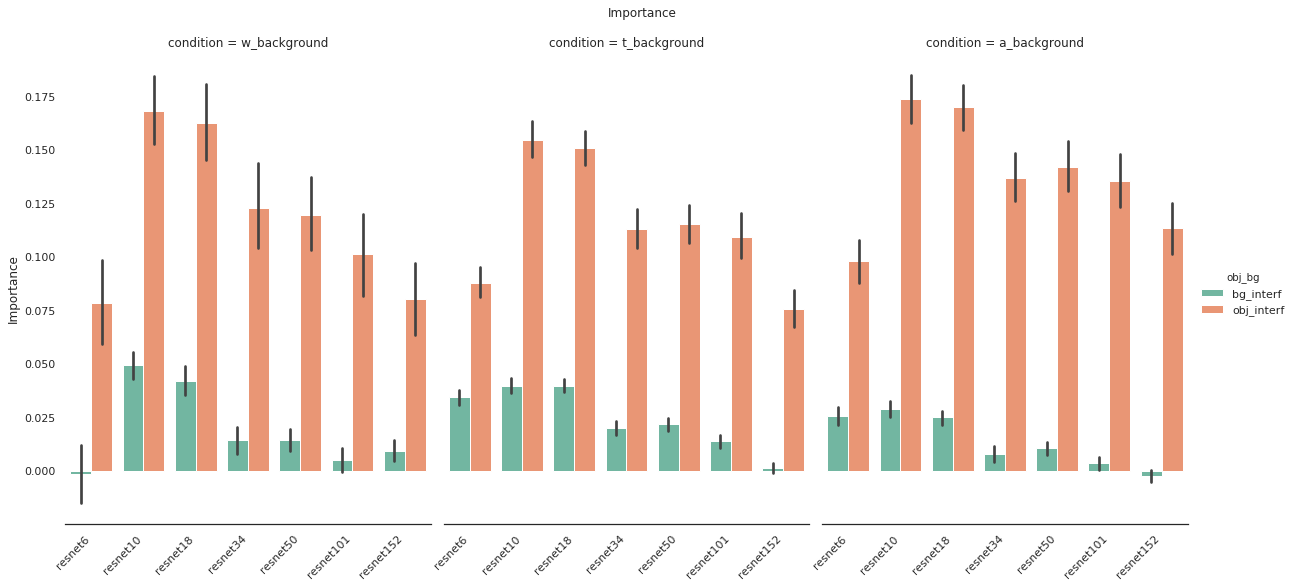

In [6]:
resnets.to_csv('resnets_data_occlusion.csv')

g = sns.catplot(x="model", y="interf_ratio",
                col="condition",hue="obj_bg",
                data=resnets, kind="bar",
                col_order=["w_background", "t_background","a_background"],
                order=["resnet6", "resnet10", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152"],
                palette="Set2",
                ci=95,
                height=8, aspect=.7);

(g.set_axis_labels("", "Importance")
  .despine(left=True))

g.set_xticklabels(rotation=45,horizontalalignment='right')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Importance')

plt.savefig("importanceratio.pdf", dpi=300)

In [ ]:
from pingouin import  read_dataset, mwu
from statsmodels.stats.multitest import multipletests

conditions = ['w_background','t_background','a_background']
pvals=[]

for condition in conditions: 
    all_x = ['resnet152','resnet152','resnet152','resnet152','resnet152','resnet152','resnet6','resnet6','resnet6','resnet6','resnet6','resnet18','resnet18','resnet18','resnet18','resnet101','resnet101','resnet101','resnet50','resnet50','resnet10']
    all_y = ["resnet6","resnet18","resnet101","resnet50","resnet10","resnet34","resnet18","resnet101","resnet50","resnet10","resnet34","resnet101","resnet50","resnet10","resnet34","resnet50","resnet10","resnet34","resnet10","resnet34","resnet34"]

    data = resnets[resnets['obj_bg']=='obj_interf']
    data= data[data['condition']==condition]

    x = data[data['model']=='resnet152']
    x = x['interf_ratio']
    y = resnets[resnets['model']=='resnet10']
    y= y['interf_ratio']

    for i in range(21):
        x = data[data['model']==all_x[i]]
        x = x['interf_ratio']
        y = data[data['model']==all_y[i]]
        y= y['interf_ratio']

        if i == 0 and condition=='t_background':
            posthocs = mwu(x,y, tail='two-sided') 
        else:
            posthocs = posthocs.append(mwu(x,y, tail='two-sided'))

pvals=posthocs['p-val']
yy=multipletests(pvals=pvals,alpha=0.05,method="fdr_bh")

posthocs['p_adj'] = yy[1]
posthocs.to_csv('posthocs_occlusion.csv')
